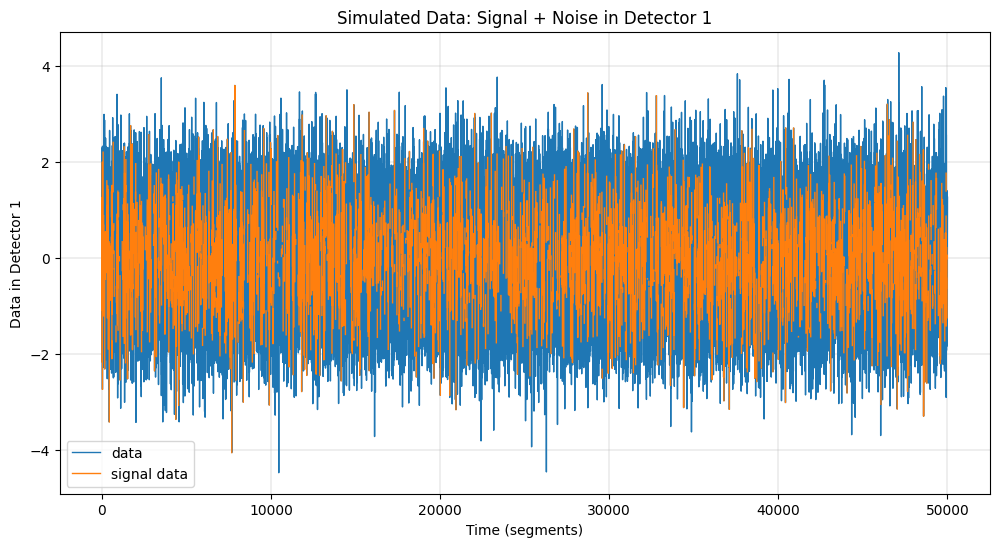

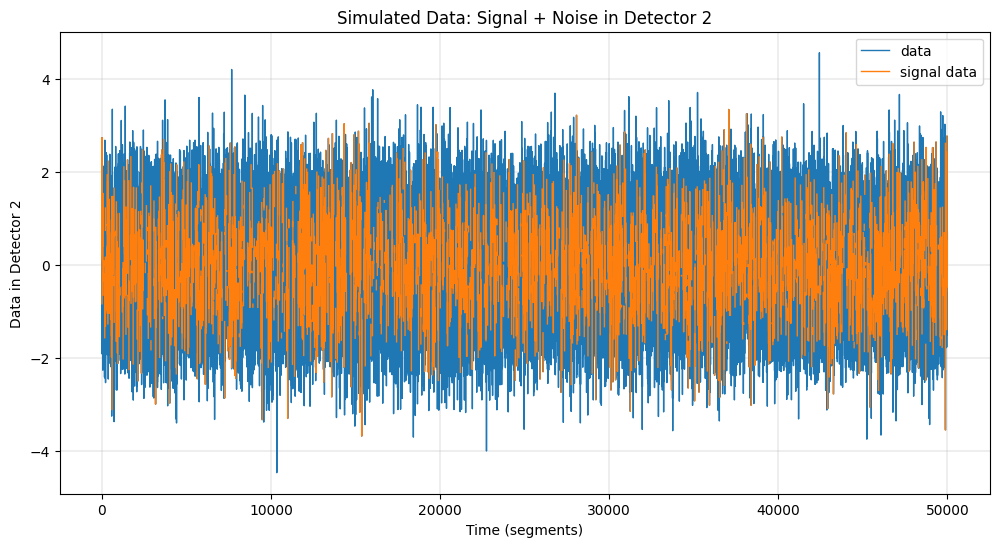

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
total_segments = 50000  # 总数据段数
signal_probability = 0.2  # 信号 Duty Cycle
sampling_rate = 4096  # 采样率
duration = 1  # 每段数据持续时间

# 噪声与信号的特性
noise_std_1 = 1.0  # 探测器1噪声标准差
noise_std_2 = 1.0  # 探测器2噪声标准差
signal_std = 0.3  # 信号标准差

# 设置随机数种子以保证结果可重复
np.random.seed(42)

# 数据段初始化
data_detector_1 = np.zeros(total_segments)
data_detector_2 = np.zeros(total_segments)

# 随机生成信号段（稀疏信号）
signal_mask = np.random.rand(total_segments) < signal_probability

# 生成共享信号 h
signal_h = np.zeros(total_segments)
signal_h[signal_mask] = np.random.normal(0, signal_std, size=np.sum(signal_mask))

# 添加噪声
data_detector_1 = signal_h + np.random.normal(0, noise_std_1, total_segments)
data_detector_2 = signal_h + np.random.normal(0, noise_std_2, total_segments)

# 构建信号数据，仅保留信号段的值，其余置为 NaN
signal_data_1 = np.full_like(data_detector_1, np.nan)
signal_data_2 = np.full_like(data_detector_2, np.nan)
signal_data_1[signal_mask] = data_detector_1[signal_mask]
signal_data_2[signal_mask] = data_detector_2[signal_mask]

# 绘制探测器1数据
plt.figure(figsize=(12, 6))
plt.plot(range(total_segments), data_detector_1, color="#1f77b4", linewidth=1.0, label="data")
plt.plot(range(total_segments), signal_data_1, color="#ff7f0e", linewidth=1.0, label="signal data")
plt.xlabel("Time (segments)")
plt.ylabel("Data in Detector 1")
plt.title("Simulated Data: Signal + Noise in Detector 1")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

# 绘制探测器2数据
plt.figure(figsize=(12, 6))
plt.plot(range(total_segments), data_detector_2, color="#1f77b4", linewidth=1.0, label="data")
plt.plot(range(total_segments), signal_data_2, color="#ff7f0e", linewidth=1.0, label="signal data")
plt.xlabel("Time (segments)")
plt.ylabel("Data in Detector 2")
plt.title("Simulated Data: Signal + Noise in Detector 2")
plt.legend()
plt.grid(True, linewidth=0.3)
plt.show()

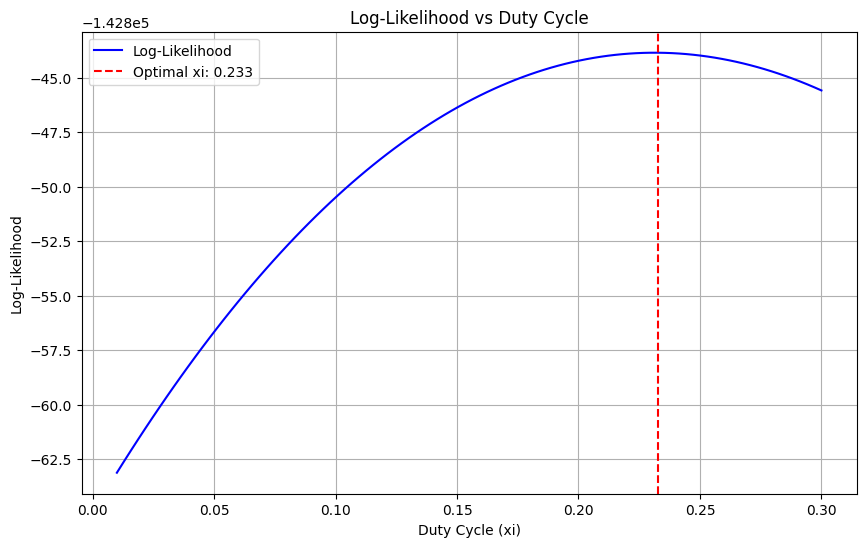

Optimal Duty Cycle (xi): 0.233


In [2]:
# 计算协方差矩阵
def covariance_matrix(sigma_n1, sigma_n2, sigma_h):
    C = np.array([
        [sigma_n1**2 + sigma_h**2, sigma_h**2],
        [sigma_h**2, sigma_n2**2 + sigma_h**2]
    ])
    det_C = (sigma_n1**2 + sigma_h**2)*(sigma_n2**2 + sigma_h**2) - (sigma_h**2)**2
    if det_C <= 0:
        raise ValueError("Covariance matrix determinant is non-positive, indicating numerical instability.")
    inv_C = (1 / det_C) * np.array([
        [sigma_n2**2 + sigma_h**2, -sigma_h**2],
        [-sigma_h**2, sigma_n1**2 + sigma_h**2]
    ])
    return C, inv_C, det_C

# 计算联合概率密度
def joint_pdf(s1, s2, sigma_n1, sigma_n2, sigma_h):
    _, inv_C, det_C = covariance_matrix(sigma_n1, sigma_n2, sigma_h)
    d = np.array([s1, s2])
    exponent = -0.5 * (d.T @ inv_C @ d)
    normalization = 1 / (2 * np.pi * np.sqrt(det_C))
    return normalization * np.exp(exponent)

# 优化 Duty Cycle
def optimize_duty_cycle(data1, data2, sigma_n1, sigma_n2, signal_std, xi_range):
    log_likelihoods = []
    for xi in xi_range:
        sigma_h = np.sqrt(xi) * signal_std  # 根据 xi 调整信号标准差
        log_likelihood = 0
        for s1, s2 in zip(data1, data2):
            pdf_value = joint_pdf(s1, s2, sigma_n1, sigma_n2, sigma_h)
            log_likelihood += np.log(pdf_value + 1e-12)  # 防止 log(0)
        log_likelihoods.append(log_likelihood)
    max_index = np.argmax(log_likelihoods)
    return xi_range[max_index], log_likelihoods

# 优化过程
xi_range = np.linspace(0.01, 0.3, 100)  # Duty Cycle 范围
optimal_xi, log_likelihoods = optimize_duty_cycle(
    data_detector_1,
    data_detector_2,
    noise_std_1,
    noise_std_2,
    signal_std,
    xi_range
)

# 绘制 Log-Likelihood 曲线
plt.figure(figsize=(10, 6))
plt.plot(xi_range, log_likelihoods, label="Log-Likelihood", color="blue")
plt.axvline(optimal_xi, color="red", linestyle="--", label=f"Optimal xi: {optimal_xi:.3f}")
plt.xlabel("Duty Cycle (xi)")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood vs Duty Cycle")
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal Duty Cycle (xi): {optimal_xi:.3f}")

In [3]:
# SNR 计算
N = len(data_detector_1)
Gamma_2 = np.mean(data_detector_1 * data_detector_2)

sigma_h2 = signal_std**2  # 信号方差（共享信号）
sigma_n1 = noise_std_1
sigma_n2 = noise_std_2

E_Gamma2 = signal_probability * sigma_h2
Var_Gamma2 = (sigma_n1**2 * sigma_n2**2) / N

snr = np.sqrt(E_Gamma2**2 / Var_Gamma2)
print(f"Calculated SNR: {snr:.3f}")
print(f"Expected Gamma_2 (E[Gamma_2]): {E_Gamma2:.6f}")
print(f"Variance of Gamma_2 (Var[Gamma_2]): {Var_Gamma2:.6f}")

Calculated SNR: 4.025
Expected Gamma_2 (E[Gamma_2]): 0.018000
Variance of Gamma_2 (Var[Gamma_2]): 0.000020


In [4]:
# 偏度和峰度计算（基于高阶累积量）
signal_data_combined = data_detector_1 + data_detector_2
signal_data_mean = np.mean(signal_data_combined)
signal_data_std = np.std(signal_data_combined)

# 偏度
signal_skewness = np.sum(((signal_data_combined - signal_data_mean) / signal_data_std) ** 3) / len(signal_data_combined)

# 峰度
signal_kurtosis = np.sum(((signal_data_combined - signal_data_mean) / signal_data_std) ** 4) / len(signal_data_combined) - 3

# 打印偏度和峰度结果
print(f"Skewness of Signal Data (Cumulant-Based): {signal_skewness}")
print(f"Kurtosis of Signal Data (Cumulant-Based): {signal_kurtosis}")

Skewness of Signal Data (Cumulant-Based): -0.004279783830546035
Kurtosis of Signal Data (Cumulant-Based): 0.03131581762817959


Running MCMC sampling...


100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 178.11it/s]


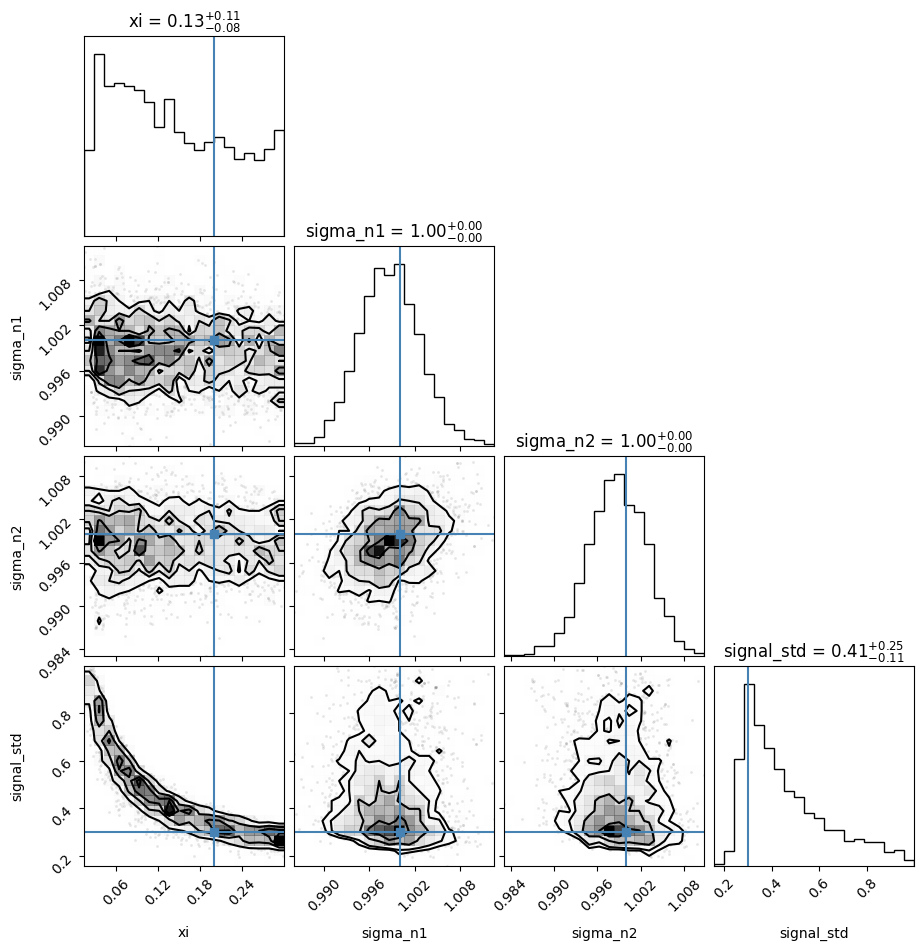

Parameter estimates:
xi: 0.129 (+0.113, -0.078)
sigma_n1: 0.999 (+0.004, -0.004)
sigma_n2: 0.999 (+0.004, -0.004)
signal_std: 0.408 (+0.246, -0.108)


In [5]:
# ------------------ MCMC ------------------
import emcee
import corner

# 定义参数的先验分布
def log_prior(theta):
    xi, sigma_n1, sigma_n2, signal_std_param = theta
    if 0.01 < xi < 0.3 and sigma_n1 > 0 and sigma_n2 > 0 and 0 < signal_std_param < 1.0:
        return 0.0  # 使用均匀先验
    else:
        return -np.inf  # 参数在不合法范围，返回负无穷

# 定义似然函数
def log_likelihood(theta, data1, data2):
    xi, sigma_n1, sigma_n2, signal_std_param = theta
    if xi <= 0 or xi >= 1 or sigma_n1 <= 0 or sigma_n2 <= 0 or signal_std_param <= 0:
        return -np.inf
    sigma_h = np.sqrt(xi) * signal_std_param
    try:
        _, inv_C, det_C = covariance_matrix(sigma_n1, sigma_n2, sigma_h)
    except ValueError:
        return -np.inf
    # 矢量化计算
    d = np.vstack([data1, data2])  # 形状为 (2, N)
    exponents = -0.5 * np.einsum('ni,ij,nj->n', d.T, inv_C, d.T)
    normalization = -np.log(2 * np.pi) - 0.5 * np.log(det_C)
    log_likelihood = np.sum(exponents + normalization)
    return log_likelihood

# 定义后验概率函数
def log_posterior(theta, data1, data2):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, data1, data2)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

# 设置 MCMC 采样器
ndim = 4  # 参数维度：xi, sigma_n1, sigma_n2, signal_std_param
nwalkers = 32  # MCMC walker 的数量

# 初始化 walker 的位置
initial = [optimal_xi, noise_std_1, noise_std_2, signal_std]
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_detector_1, data_detector_2))

# 运行采样
print("Running MCMC sampling...")
nsteps = 1000  # 采样步数
sampler.run_mcmc(p0, nsteps, progress=True)

# 获取采样结果
samples = sampler.get_chain(discard=200, thin=10, flat=True)  # 扔掉前200步，每隔10步取一次，展开为二维数组

# 绘制参数的后验分布
labels = ["xi", "sigma_n1", "sigma_n2", "signal_std"]
truths = [signal_probability, noise_std_1, noise_std_2, signal_std]

fig = corner.corner(samples, labels=labels, truths=truths, show_titles=True)
plt.show()

# 打印参数的估计值
import pandas as pd

df = pd.DataFrame(samples, columns=labels)
print("Parameter estimates:")
for param in labels:
    mcmc = np.percentile(df[param], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{param}: {mcmc[1]:.3f} (+{q[1]:.3f}, -{q[0]:.3f})")